## Setup Environment

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pathlib
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch import optim

from sklearn.model_selection import train_test_split
from time import time
from tqdm import tqdm

In [3]:
# # For training on Colab
# import os
# from google.colab import drive
# drive.mount('/content/drive')
# os.chdir('/content/drive/My Drive/chem_vae')

## Declare Constants

In [4]:
MAX_LEN = 120
NLATENT = 196
DECODER_HIDDEN_SIZE = 488
DECODER_NUM_LAYERS = 3

DATA_DIR = './data'
DATA_FILE_NAME = '250k_rndm_zinc_drugs_clean_3.csv'
CHAR_FILE_NAME = 'zinc.json'
TEST_IDX_FILE_NAME = 'test_idx.npy'

ALL_LETTERS = yaml.safe_load(open(pathlib.Path(DATA_DIR, CHAR_FILE_NAME))) + ['SOS']
N_LETTERS = len(ALL_LETTERS) 

MODELS_DIR = './models'

## Create a Utility Class

In [5]:
class VAEUtils:
    '''
    This purpose of this class is to help with various aspects
    of data processing
    '''
    
    def __init__(self, data_dir=DATA_DIR, 
                 data_file_name=DATA_FILE_NAME, 
                 test_idx_file_name=TEST_IDX_FILE_NAME,
                 max_len=MAX_LEN,
                 all_letters=ALL_LETTERS):
        
        self.data_dir = pathlib.Path(data_dir)
        self.data_file = self.data_dir / pathlib.Path(data_file_name)
        self.test_file = self.data_dir / pathlib.Path(test_idx_file_name)
        
        self.max_len = max_len
        
        self.all_letters = all_letters
        self.n_letters = len(all_letters)
        self.letters_to_indices_dict = dict((l, i) for i, l in enumerate(all_letters))
        self.indices_to_letters_dict = dict((i, l) for i, l in enumerate(all_letters))
               
    def get_data_df(self):
        df = pd.read_csv(self.data_file)
        df = df[df.smiles.str.len() <= self.max_len].reset_index(drop=True)
        
        # preprocess input smile to remove the newline character and add padding
        df.loc[:, 'smiles'] = df.loc[:, 'smiles'].str.strip()\
                    .str.pad(width=self.max_len, side='right', fillchar=" ")
        
        return df
        
    # One-hot matrix of first to last letters (not including EOS) for input
    def get_input_tensor(self, smile):
        tensor = torch.zeros(1, len(smile), self.n_letters) # batch_size * seq_length * num_features
        for i, letter in enumerate(smile):
            tensor[0][i][self.letters_to_indices_dict[letter]] = 1
        return tensor

    # LongTensor of first letter to end (EOS) for target
    def get_target_tensor(self, smile):
        letter_indexes = [self.letters_to_indices_dict[l] for l in smile]
        # letter_indexes.append(self.n_letters - 1) # EOS
        return torch.LongTensor(letter_indexes)
    
    def get_train_valid_test_splits(self, reg_col, valid_pct=.1):
        df = self.get_data_df()[['smiles', reg_col]]
        df = df.rename(columns={reg_col: 'reg_col'})
        
        test_idx = np.load(self.test_file)
        non_test_idx = np.array(df[~df.index.isin(test_idx)].index)
        train_idx, valid_idx = train_test_split(non_test_idx, test_size=valid_pct, 
                                                random_state=42, shuffle=True)
        
        assert len(df) == len(test_idx) + len(train_idx) + len(valid_idx)
        
        return df, train_idx, valid_idx, test_idx
         
    def get_dl(self, df, idx, bs, shuffle=False):
        
        df = df.iloc[idx]
        
        input_tensors = torch.zeros(len(df), self.max_len, self.n_letters)
        target_tensors = torch.zeros(len(df), self.max_len, dtype=torch.long)
        for i, smile in enumerate(tqdm(df.smiles)):
            input_tensors[i] = self.get_input_tensor(smile)
            target_tensors[i] = self.get_target_tensor(smile)
        
        input_tensors = input_tensors
        target_tensors = target_tensors
        
        # original_lengths = torch.tensor(df.smiles.str.strip().str.len().to_numpy())

        property_values = torch.tensor(df.reg_col.to_numpy()).type(torch.float32)
         
        ds = TensorDataset(input_tensors, target_tensors, property_values)
        dl = DataLoader(ds, shuffle=shuffle, batch_size=bs)
        
        return dl
    
vae_utils = VAEUtils()

## Create the Model Networks

In [6]:
class Lambda(nn.Module):
    '''
    This class simplifies layers from 
    custom functions
    '''
    def __init__(self, func):
        super().__init__()
        self.func = func
    
    def forward(self, x):
        return self.func(x)

In [7]:
class Encoder(nn.Module):
    def __init__(self, n_letters, nlatent, decoder_hidden_size):
        super().__init__()
        self.n_letters = n_letters
        self.nlatent = nlatent
        self.decoder_hidden_size = decoder_hidden_size
        self.encoder = nn.Sequential(
            Lambda(lambda x: x.permute(0, 2, 1)), # the features are in the channels dimension
            nn.Conv1d(in_channels=n_letters, out_channels=9, kernel_size=9),
            # nn.Tanh(), # the authors of the paper used tanh
            nn.ReLU(),
            nn.BatchNorm1d(9), # the authors of the paper did batch normalization
            nn.Conv1d(in_channels=9, out_channels=9, kernel_size=9),
            # nn.Tanh(), # the authors of the paper used tanh
            nn.ReLU(),
            nn.BatchNorm1d(9), # the authors of the paper did batch normalization
            nn.Conv1d(in_channels=9, out_channels=11, kernel_size=10),
            # nn.Tanh(), # the authors of the paper used tanh
            nn.ReLU(),
            nn.BatchNorm1d(11), # the authors of the paper did batch normalization
            nn.Flatten()
        )
        
        self.mean = nn.Linear(1045, nlatent)
        self.log_var = nn.Linear(1045, nlatent)
        self.dec_init_hidden = nn.Linear(nlatent, decoder_hidden_size)
        
    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var) 
        eps = torch.randn_like(std)
        sample = mean + (eps * std) 
        return sample
        
    def forward(self, x):
        x = self.encoder(x)
        mean = self.mean(x)
        log_var = self.log_var(x)
        z = self.reparameterize(mean, log_var)
        dec_init_hidden = self.dec_init_hidden(z)
        
        return z, mean, log_var, dec_init_hidden

In [8]:
def preprocess_decoder_input(input_tensors):
    '''
    Adjust for SOS and make batch the second demension
    '''
    sos_tensor = torch.zeros(1, N_LETTERS)
    sos_tensor[0][vae_utils.letters_to_indices_dict['SOS']] = 1
    new_tensor = torch.zeros(input_tensors.shape[0], MAX_LEN, N_LETTERS)
    new_tensor[:][0] = sos_tensor
    new_tensor[:, 1:MAX_LEN, :] = input_tensors[:, 0:MAX_LEN-1, :]
    new_tensor = new_tensor.permute(1, 0, 2).to(input_tensors.device)
    
    return new_tensor

In [9]:
class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.preprocess = Lambda(preprocess_decoder_input)
        self.rnn = nn.GRU(input_size, hidden_size, num_layers)
        self.out = nn.Linear(hidden_size, input_size)
        self.softmax = nn.LogSoftmax(dim=2)
        
    def forward(self, input, hidden):
        output, hidden = self.rnn(self.preprocess(input), )
        output = output.permute(1, 0, 2)
        output = self.softmax(self.out(output))
        return output, hidden

In [10]:
class PropertyPredictor(nn.Module):
    def __init__(self, nlatent):
        super().__init__()
        self.predictor = nn.Sequential(
            nn.Linear(nlatent, 1000),
            # nn.Tanh(), # the authors of the paper used tanh
            nn.ReLU(),
            nn.Dropout(.2),
            nn.Linear(1000, 1000),
            # nn.Tanh(), # the authors of the paper used tanh
            nn.ReLU(),
            nn.Dropout(.2),
            nn.Linear(1000, 1)
        )
        
    def forward(self, x):
        return self.predictor(x) 

## Write Helper Classes & Functions for Training and Testing

In [11]:
class Trainer:
    def __init__(self, reg_col):
        
        self.reg_col = reg_col
        models_dir = pathlib.Path(MODELS_DIR)
        models_dir.mkdir(exist_ok=True, parents=True)
        self.encoder_file = models_dir / pathlib.Path(f'{reg_col}_encoder.pth')
        self.decoder_file = models_dir / pathlib.Path(f'{reg_col}_decoder.pth')
        self.property_predictor_file = models_dir / pathlib.Path(f'{reg_col}_property_predictor.pth')
        self.train_losses_file = models_dir / pathlib.Path(f'{reg_col}_train_losses.csv')
        self.val_losses_file = models_dir / pathlib.Path(f'{reg_col}_valid_losses.csv')

        self.loss_columns = ['total_loss', 'reconstruction_loss', 'kl_divergence', 'regression_loss']
        self.train_losses_df = pd.DataFrame(columns=self.loss_columns)
        self.val_losses_df = pd.DataFrame(columns=self.loss_columns)

    def intitialize_networks(self):
        self.encoder = Encoder(vae_utils.n_letters, NLATENT, DECODER_HIDDEN_SIZE)
        self.decoder = Decoder(vae_utils.n_letters, DECODER_HIDDEN_SIZE, DECODER_NUM_LAYERS)
        self.property_predictor = PropertyPredictor(NLATENT)
        
    def __time_since(self, since):
        now = time()
        s = now - since
        m = math.floor(s / 60)
        s -= m * 60
        return f'{m}m {s:.0f}s'     
        
    def kl_anneal_function(self, epoch, anneal_start, k=1):
        return 1 / (1 + np.exp(- k * (epoch - anneal_start)))
    
    def get_losses(self, epoch, input_tensors, target_tensors, property_values):
                
        reconstruction_loss_func = nn.NLLLoss()
        reg_loss_func = nn.MSELoss()
        
        input_tensors = input_tensors.to(device)
        target_tensors = target_tensors.to(device)
        property_values = property_values.to(device)

        z, mean, log_var, dec_init_hidden = self.encoder(input_tensors)
        output, hidden = self.decoder(input_tensors, 
                                 dec_init_hidden.unsqueeze(0).repeat(DECODER_NUM_LAYERS, 1, 1))
        reg_pred = self.property_predictor(mean)

        kl_divergence = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
        kl_weight = self.kl_anneal_function(epoch, anneal_start)

        reg_loss = reg_loss_func(reg_pred.flatten(), property_values)
        reg_loss = reg_loss.type(torch.float32) 

        reconstruction_loss = reconstruction_loss_func(output.permute(0, 2, 1), target_tensors)

        loss = reconstruction_loss + kl_divergence * kl_weight + reg_loss
        
        return loss, reconstruction_loss, kl_divergence, reg_loss
    
    def process_dl(self, epoch, anneal_start, device, dl, train, 
                   enc_opt=None, dec_opt=None, pp_opt=None):
        
        num_loaders = len(dl)
        loader_loss = 0
        recon_loss_epoch = 0
        kld_epoch = 0
        reg_loss_epoch = 0
        
        for input_tensors, target_tensors, property_values in dl:
            loss, reconstruction_loss, kl_divergence, reg_loss = \
                self.get_losses(epoch, input_tensors, target_tensors, property_values)
            
            if train:
                enc_opt.zero_grad()
                dec_opt.zero_grad()
                pp_opt.zero_grad()
                
                loss.backward()
                
                enc_opt.step()
                dec_opt.step()
                pp_opt.step()
                
            loader_loss += loss.item()
            recon_loss_epoch += reconstruction_loss.item()
            kld_epoch += kl_divergence.item()
            reg_loss_epoch += reg_loss.item()
        
        loader_loss /= num_loaders
        recon_loss_epoch /= num_loaders
        kld_epoch /= num_loaders
        reg_loss_epoch /= num_loaders
        
        return (loader_loss, recon_loss_epoch, kld_epoch, reg_loss_epoch)
    
    def save_parameters_and_losses(self, train_losses:list, val_losses:list):
        
        torch.save(self.encoder.state_dict(), self.encoder_file)
        torch.save(self.decoder.state_dict(), self.decoder_file)
        torch.save(self.property_predictor.state_dict(), self.property_predictor_file)
        
        temp_df = pd.DataFrame(data=train_losses, columns=self.loss_columns)
        self.train_losses_df = self.train_losses_df.append(temp_df, ignore_index=True)
        self.train_losses_df.to_csv(self.train_losses_file, index=False)
        
        temp_df = pd.DataFrame(data=val_losses, columns=self.loss_columns)
        self.val_losses_df = self.val_losses_df.append(temp_df, ignore_index=True)
        self.val_losses_df.to_csv(self.val_losses_file, index=False)
        
    def load_parameters_and_losses(self):
        self.encoder.load_state_dict(torch.load(self.encoder_file))
        self.decoder.load_state_dict(torch.load(self.decoder_file))
        self.property_predictor.load_state_dict(torch.load(self.property_predictor_file))
        self.train_losses_df = pd.read_csv(self.train_losses_file)
        self.val_losses_df = pd.read_csv(self.val_losses_file)
        
    
    def fit(self, epochs, save_every, anneal_start, lr, train_dl, valid_dl, device, load_previous=False):
        
        self.intitialize_networks()
    
        if load_previous:
            self.load_parameters_and_losses()
            
        self.encoder = self.encoder.to(device)
        self.decoder = self.decoder.to(device)
        self.property_predictor = self.property_predictor.to(device)

        enc_opt = optim.Adam(self.encoder.parameters(), lr=lr)
        dec_opt = optim.Adam(self.decoder.parameters(), lr=lr)
        pp_opt = optim.Adam(self.property_predictor.parameters(), lr=lr)

        train_losses = []
        val_losses = []
        prev_n_epochs = len(self.train_losses_df) 

        start_time = time()
        for epoch in tqdm(range(prev_n_epochs, epochs)):
            self.encoder.train()
            self.decoder.train()
            self.property_predictor.train()
            train_loss = self.process_dl(epoch, anneal_start, device, 
                                           train_dl, True, enc_opt, dec_opt, pp_opt)
            train_losses.append(train_loss)

            self.encoder.eval()
            self.decoder.eval()
            self.property_predictor.eval()
            with torch.no_grad():
                val_loss = self.process_dl(epoch, anneal_start, device,
                                             valid_dl, False)
                val_losses.append(val_loss)
                
            # if epoch % 5 == 4:
            print(f"Epoch: {epoch + 1:3d} | " + \
                  f"Train Loss: {train_loss[0]:10.5f} | Val Loss: {val_loss[0]:10.5f} | " + \
                  f"Time Taken: {self.__time_since(start_time)}")
            print(f"Train Recon Loss: {train_loss[1]:10.5f} | Val Recon Loss: {val_loss[1]:10.5f}")
            print(f"Train KLD: {train_loss[2]:10.5f} | Val KLD: {val_loss[2]:10.5f}")
            print(f"Train Reg Loss: {train_loss[3]:10.5f} | Val Reg Loss: {val_loss[3]:10.5f}\n")
            
            if epoch % save_every == save_every - 1:
                self.save_parameters_and_losses(train_losses, val_losses)
                train_losses = []
                val_losses = []
            
        self.save_parameters_and_losses(train_losses, val_losses)
        
        del self.encoder
        del self.decoder
        del self.property_predictor
        
    def plot_losses(self):
        
        train_losses_df = pd.read_csv(self.train_losses_file)
        val_losses_df = pd.read_csv(self.val_losses_file)
        
        plt.rcParams.update({'font.size': 15})
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20,10))
        
                
        ax1.plot(train_losses_df['total_loss'], label='Train')
        ax1.plot(val_losses_df['total_loss'], label='Validation')
        ax1.set_ylabel('Total Loss')
        ax1.legend(loc='upper right')
        
        ax2.plot(train_losses_df['reconstruction_loss'], label='Train')
        ax2.plot(val_losses_df['reconstruction_loss'], label='Validation')
        ax2.set_ylabel('Reconstruction Loss')
        ax2.legend(loc='upper right')
        
        ax3.plot(train_losses_df['kl_divergence'], label='Train')
        ax3.plot(val_losses_df['kl_divergence'], label='Validation')
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('KL Divergence')
        ax3.legend(loc='upper right')
        
        
        ax4.plot(train_losses_df['regression_loss'], label='Train')
        ax4.plot(val_losses_df['regression_loss'], label='Validation')
        ax4.set_xlabel('Epoch')
        ax4.set_ylabel('Regression Loss')
        ax4.legend(loc='upper right')
        
        plt.savefig(pathlib.Path(MODELS_DIR, f"{self.reg_col}_losses.png"))
        plt.show()

In [12]:
def get_dataloaders(df, train_idx, valid_idx, max_samples, bs):
    start_time = time()
    train_dl = vae_utils.get_dl(df, train_idx[:max_samples], bs, shuffle=True)
    valid_dl = vae_utils.get_dl(df, valid_idx[:max_samples], bs)
    print(f'Time taken to get dataloaders: {time() - start_time:.2f}s')
    
    return train_dl, valid_dl

In [13]:
def get_pred_mae(reg_col, df, test_idx, bs):
    encoder = Encoder(vae_utils.n_letters, NLATENT, DECODER_HIDDEN_SIZE)
    property_predictor = PropertyPredictor(NLATENT)

    encoder.load_state_dict(torch.load(pathlib.Path(MODELS_DIR, f'{reg_col}_encoder.pth')))
    property_predictor.load_state_dict(torch.load(pathlib.Path(MODELS_DIR, f'{reg_col}_property_predictor.pth')))
    
    dl = vae_utils.get_dl(df, test_idx, bs)
    
    encoder.eval()
    property_predictor.eval()
    
    with torch.no_grad():
        abs_errors = []
        for input_tensors, target_tensors, property_values in dl:
            z, mean, log_var, dec_init_hidden = encoder(input_tensors)
            reg_pred = property_predictor(mean)
            abs_error = torch.abs(property_values - reg_pred.flatten())
            abs_errors.append(abs_error)
            
        abs_errors = torch.cat(abs_errors)
        mae_error = abs_errors.mean()
        
    return mae_error

## Define Parameters for Training

In [14]:
valid_pct = .1
bs = 128
max_samples = 250000
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device("cpu")
# device = torch.device("cpu")
epochs = 120
save_every = 2
anneal_start = 29
lr = 0.0005
load_previous = True

## Train and Test the Network for _logP_

In [15]:
errors = {}

In [ ]:
reg_col = 'logP'
df, train_idx, valid_idx, test_idx = vae_utils.get_train_valid_test_splits(reg_col, valid_pct)
trainer = Trainer(reg_col)
train_dl, valid_dl = get_dataloaders(df, train_idx, valid_idx, max_samples, bs)
trainer.fit(epochs, save_every, anneal_start, lr, train_dl, valid_dl, device, load_previous)

100%|██████████| 24891/24891 [00:39<00:00, 624.15it/s]


Time taken to get dataloaders: 404.80s


  2%|▏         | 1/56 [02:34<2:21:16, 154.12s/it]

Epoch:  65 | Train Loss:    0.21015 | Val Loss:    0.29694 | Time Taken: 2m 34s
Train Recon Loss:    0.16160 | Val Recon Loss:    0.20892
Train KLD:    0.00719 | Val KLD:    0.01275
Train Reg Loss:    0.04136 | Val Reg Loss:    0.07527

Epoch:  66 | Train Loss:    0.20959 | Val Loss:    0.24271 | Time Taken: 5m 20s
Train Recon Loss:    0.16125 | Val Recon Loss:    0.20885
Train KLD:    0.00688 | Val KLD:    0.00621
Train Reg Loss:    0.04146 | Val Reg Loss:    0.02765



  5%|▌         | 3/56 [07:58<2:21:07, 159.76s/it]

Epoch:  67 | Train Loss:    0.21075 | Val Loss:    0.25236 | Time Taken: 7m 58s
Train Recon Loss:    0.16103 | Val Recon Loss:    0.21012
Train KLD:    0.00726 | Val KLD:    0.00619
Train Reg Loss:    0.04246 | Val Reg Loss:    0.03605

Epoch:  68 | Train Loss:    0.21031 | Val Loss:    0.26856 | Time Taken: 10m 38s
Train Recon Loss:    0.16086 | Val Recon Loss:    0.20943
Train KLD:    0.00744 | Val KLD:    0.01092
Train Reg Loss:    0.04200 | Val Reg Loss:    0.04820



  9%|▉         | 5/56 [13:19<2:16:15, 160.30s/it]

Epoch:  69 | Train Loss:    0.20938 | Val Loss:    0.27835 | Time Taken: 13m 19s
Train Recon Loss:    0.16065 | Val Recon Loss:    0.20995
Train KLD:    0.00734 | Val KLD:    0.00699
Train Reg Loss:    0.04140 | Val Reg Loss:    0.06141

Epoch:  70 | Train Loss:    0.20808 | Val Loss:    0.30147 | Time Taken: 15m 59s
Train Recon Loss:    0.16046 | Val Recon Loss:    0.20953
Train KLD:    0.00693 | Val KLD:    0.00631
Train Reg Loss:    0.04069 | Val Reg Loss:    0.08563



 12%|█▎        | 7/56 [18:40<2:11:00, 160.42s/it]

Epoch:  71 | Train Loss:    0.20676 | Val Loss:    0.24509 | Time Taken: 18m 40s
Train Recon Loss:    0.16038 | Val Recon Loss:    0.20993
Train KLD:    0.00634 | Val KLD:    0.00599
Train Reg Loss:    0.04004 | Val Reg Loss:    0.02917

Epoch:  72 | Train Loss:    0.20696 | Val Loss:    0.24779 | Time Taken: 21m 21s
Train Recon Loss:    0.16022 | Val Recon Loss:    0.21027
Train KLD:    0.00671 | Val KLD:    0.00673
Train Reg Loss:    0.04003 | Val Reg Loss:    0.03079



 16%|█▌        | 9/56 [24:02<2:05:58, 160.82s/it]

Epoch:  73 | Train Loss:    0.20822 | Val Loss:    0.26161 | Time Taken: 24m 2s
Train Recon Loss:    0.16003 | Val Recon Loss:    0.21040
Train KLD:    0.00678 | Val KLD:    0.02110
Train Reg Loss:    0.04140 | Val Reg Loss:    0.03011

Epoch:  74 | Train Loss:    0.20807 | Val Loss:    0.28286 | Time Taken: 26m 45s
Train Recon Loss:    0.15980 | Val Recon Loss:    0.21065
Train KLD:    0.00704 | Val KLD:    0.00602
Train Reg Loss:    0.04123 | Val Reg Loss:    0.06618



 20%|█▉        | 11/56 [29:30<2:01:53, 162.52s/it]

Epoch:  75 | Train Loss:    0.20777 | Val Loss:    0.25468 | Time Taken: 29m 30s
Train Recon Loss:    0.15973 | Val Recon Loss:    0.21086
Train KLD:    0.00715 | Val KLD:    0.00527
Train Reg Loss:    0.04090 | Val Reg Loss:    0.03855

Epoch:  76 | Train Loss:    0.20675 | Val Loss:    0.25585 | Time Taken: 32m 15s
Train Recon Loss:    0.15958 | Val Recon Loss:    0.21073
Train KLD:    0.00658 | Val KLD:    0.00564
Train Reg Loss:    0.04058 | Val Reg Loss:    0.03948



 23%|██▎       | 13/56 [35:01<1:57:41, 164.22s/it]

Epoch:  77 | Train Loss:    0.20655 | Val Loss:    0.25406 | Time Taken: 35m 2s
Train Recon Loss:    0.15945 | Val Recon Loss:    0.21150
Train KLD:    0.00684 | Val KLD:    0.01170
Train Reg Loss:    0.04026 | Val Reg Loss:    0.03086



 27%|██▋       | 15/56 [40:30<1:52:18, 164.36s/it]

Epoch:  79 | Train Loss:    0.20553 | Val Loss:    0.54273 | Time Taken: 40m 31s
Train Recon Loss:    0.15910 | Val Recon Loss:    0.21169
Train KLD:    0.00667 | Val KLD:    0.00588
Train Reg Loss:    0.03977 | Val Reg Loss:    0.32516

Epoch:  80 | Train Loss:    0.20619 | Val Loss:    0.26492 | Time Taken: 43m 15s
Train Recon Loss:    0.15891 | Val Recon Loss:    0.21135
Train KLD:    0.00672 | Val KLD:    0.01018
Train Reg Loss:    0.04056 | Val Reg Loss:    0.04339



 30%|███       | 17/56 [45:59<1:46:49, 164.34s/it]

Epoch:  81 | Train Loss:    0.20435 | Val Loss:    0.25952 | Time Taken: 45m 59s
Train Recon Loss:    0.15887 | Val Recon Loss:    0.21203
Train KLD:    0.00632 | Val KLD:    0.00503
Train Reg Loss:    0.03917 | Val Reg Loss:    0.04246



In [ ]:
trainer.plot_losses()

In [ ]:
reg_mean_train = df.iloc[train_idx].reg_col.mean()
mean_mae_test = np.mean(np.abs(df.iloc[test_idx].reg_col - reg_mean_train))
vae_mae_test = get_pred_mae(reg_col, df, test_idx, bs).item()
errors[reg_col] = {'mean_mae_test': mean_mae_test, 'vae_mae_test': vae_mae_test}
errors

## Train and Test the Network for _QED_

In [23]:
reg_col = 'qed'
df, train_idx, valid_idx, test_idx = vae_utils.get_train_valid_test_splits(reg_col, valid_pct)
trainer = Trainer(reg_col)
# train_dl, valid_dl = get_dataloaders(df, train_idx, valid_idx, max_samples, bs)
# trainer.fit(epochs, save_every, anneal_start, lr, train_dl, valid_dl, device, load_previous)

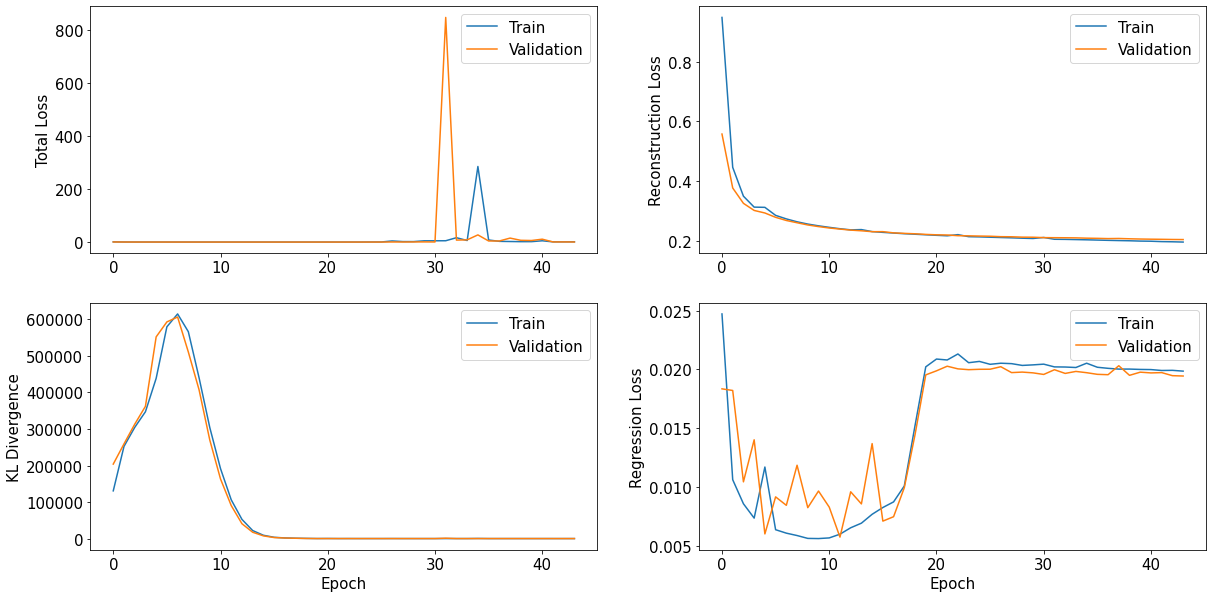

In [24]:
trainer.plot_losses()

In [25]:
reg_mean_train = df.iloc[train_idx].reg_col.mean()
mean_mae_test = np.mean(np.abs(df.iloc[test_idx].reg_col - reg_mean_train))
vae_mae_test = get_pred_mae(reg_col, df, test_idx, bs).item()
errors[reg_col] = {'mean_mae_test': mean_mae_test, 'vae_mae_test': vae_mae_test}

100%|██████████| 546/546 [00:00<00:00, 897.05it/s]


## Report the Results

In [26]:
pd.DataFrame(errors).transpose()

,mean_mae_test,vae_mae_test
logP,1.119256,1.117877
qed,0.107472,0.107403
